# Imbalanced datasets
------------------------------------

This example shows how to test different approaches to handle imbalanced datasets.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look at the data
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Run the pipeline

In [3]:
# Initialize ATOM with the created dataset
atom = ATOMClassifier(X, n_rows=0.3, test_size=0.3, verbose=2, random_state=1)
atom.clean()
atom.impute()
atom.encode()

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (42658, 22)
Scaled: False
Missing values: 95216 (10.1%)
Categorical features: 5 (22.7%)
Duplicate samples: 10 (0.0%)
-------------------------------------
Train set size: 29861
Test set size: 12797
-------------------------------------
Train set balance: No:Yes <==> 3.5:1.0
Test set balance: No:Yes <==> 3.4:1.0
-------------------------------------
|     |   dataset |   train |   test |
|:----|----------:|--------:|-------:|
| No  |     33139 |   23247 |   9892 |
| Yes |      9519 |    6614 |   2905 |

Applying data cleaning...
 --> Label-encoding the target column.
Fitting Imputer...
Imputing missing values...
 --> Dropping 191 samples due to missing values in feature MinTemp.
 --> Dropping 69 samples due to missing values in feature MaxTemp.
 --> Dropping 373 samples due to missing values in feature Rainfall.
 --> Dropping 17768 samples due to missing 

In [4]:
# First, we fit a logistic regression model directly on the imbalanced data
atom.run("LR", metric="f1", bagging=5)


Training ===================================== >>
Models: LR
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.6174
Test evaluation --> f1: 0.6096
Time elapsed: 0.092s
Bagging -----------------------------------------
Evaluation --> f1: 0.6078 ± 0.0048
Time elapsed: 0.374s
-------------------------------------------------
Total time: 0.466s


Final results ========================= >>
Duration: 0.466s
------------------------------------------
Logistic Regression --> f1: 0.6078 ± 0.0048


## Class weights

In [5]:
# Add class weights through the est_params parameter
atom.run("LR_cw", est_params={"class_weight": atom.get_class_weight()}, bagging=5)


Training ===================================== >>
Models: LR_cw
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.6449
Test evaluation --> f1: 0.6472
Time elapsed: 0.080s
Bagging -----------------------------------------
Evaluation --> f1: 0.6483 ± 0.0014
Time elapsed: 0.344s
-------------------------------------------------
Total time: 0.425s


Final results ========================= >>
Duration: 0.425s
------------------------------------------
Logistic Regression --> f1: 0.6483 ± 0.0014


## Oversampling & undersampling

In [6]:
# Create a new branch for oversampling
atom.branch = "oversampling"

New branch oversampling successfully created!


In [7]:
# Perform oversampling of the minority class
atom.balance(strategy="smote", sampling_strategy=0.9)

Oversampling with SMOTE...
 --> Adding 5830 samples to class: Yes.


In [8]:
atom.classes  # Note the balanced training set!

,dataset,train,test
0,13189,9317,3872
1,9536,8385,1151


In [9]:
atom.run("LR_os", bagging=5)


Training ===================================== >>
Models: LR_os
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.7918
Test evaluation --> f1: 0.6505
Time elapsed: 0.111s
Bagging -----------------------------------------
Evaluation --> f1: 0.6489 ± 0.0031
Time elapsed: 0.408s
-------------------------------------------------
Total time: 0.519s


Final results ========================= >>
Duration: 0.519s
------------------------------------------
Logistic Regression --> f1: 0.6489 ± 0.0031


In [10]:
# Create the undersampling branch from master
atom.branch = "undersampling_from_master"

# Note that here the data is still imbalanced!
atom.classes

New branch undersampling successfully created!


,dataset,train,test
0,13189,9317,3872
1,3706,2555,1151


In [11]:
# Perform undersampling of the majority class
atom.balance(strategy="NearMiss", sampling_strategy=0.9)

Undersampling with NearMiss...
 --> Removing 6479 samples from class: No.


In [12]:
atom.run("LR_us", bagging=5)


Training ===================================== >>
Models: LR_us
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.7829
Test evaluation --> f1: 0.6061
Time elapsed: 0.061s
Bagging -----------------------------------------
Evaluation --> f1: 0.6037 ± 0.0071
Time elapsed: 0.234s
-------------------------------------------------
Total time: 0.295s


Final results ========================= >>
Duration: 0.295s
------------------------------------------
Logistic Regression --> f1: 0.6037 ± 0.0071 ~


## Analyze results

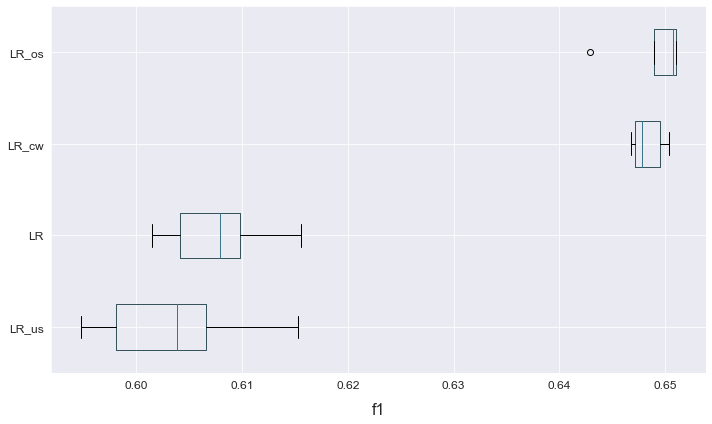

In [13]:
atom.plot_results()

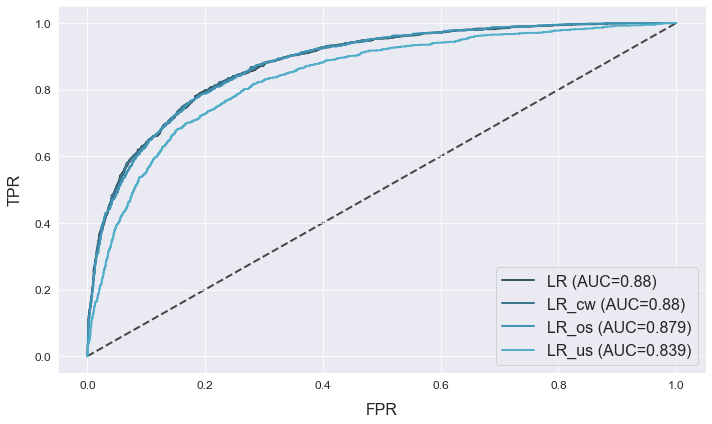

In [14]:
atom.plot_roc()